In [1]:
DATA_PATH = "data/criteo-uplift-v2.1.csv"

In [12]:
import numpy as np
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_qini_curve, plot_uplift_curve
from catboost import CatBoostClassifier
import shap
%matplotlib inline
sns.set()

In [3]:
data = pl.scan_csv(DATA_PATH)
print(data.schema)
data.head().collect()

{'f0': Float64, 'f1': Float64, 'f2': Float64, 'f3': Float64, 'f4': Float64, 'f5': Float64, 'f6': Float64, 'f7': Float64, 'f8': Float64, 'f9': Float64, 'f10': Float64, 'f11': Float64, 'treatment': Int64, 'conversion': Int64, 'visit': Int64, 'exposure': Int64}


f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64
12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [4]:
print("Treatment distribution: ")
by_treatment = data.groupby("treatment").agg(
    [pl.count().alias("num_observations"),
     pl.mean("visit").alias("visit_rate"),
     pl.mean("conversion").alias("conversion_rate"),
     pl.mean("exposure").alias("exposure_rate")
    ]

).collect()
by_treatment.with_columns((pl.col("num_observations") / pl.col("num_observations").sum()).alias("prop_observations"))

Treatment distribution: 


treatment,num_observations,visit_rate,conversion_rate,exposure_rate,prop_observations
i64,u32,f64,f64,f64,f64
0,2096937,0.038201,0.001938,0.0,0.15
1,11882655,0.048543,0.003089,0.036037,0.85


- The average treatment effect (ATE) on visit rate is about 4.8% - 3.8% = 1%. The ATE on conversion rate is also positive but substantially smaller at only .31% - .19% = .12%.
- Only 3.6% of treated subjects are actually exposed to the treatment. Suggesting the treatment is very ineffective at capturing the attention of the users.

In [5]:
print("Exposure distribution: ")
by_exposure = data.groupby("exposure").agg(
    [pl.count().alias("num_observations"),
     pl.mean("visit").alias("visit_rate"),
     pl.mean("conversion").alias("conversion_rate")
    ]

).collect()
by_exposure.with_columns((pl.col("num_observations") / pl.col("num_observations").sum()).alias("prop_observations"))

Exposure distribution: 


exposure,num_observations,visit_rate,conversion_rate,prop_observations
i64,u32,f64,f64,f64
0,13551380,0.035378,0.001309,0.969369
1,428212,0.414538,0.053784,0.030631


- The ATE on both visit rate and conversion rate is much higher for individuals that are properly exposed to the treatment.

### Uplift modeling of conversion rate
- Note: Exposure will be used as the treatment since treatment seems very ineffective if exposure doesn't happen

In [4]:
# Sample the data for faster run time
data_sample = pl.read_csv(DATA_PATH).sample(3000000)
print(data_sample.shape)
data_sample.describe()

(3000000, 16)


describe,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3e6,3e6,3e6,3e6,3e6,3e6,3e6,3e6,3e6,3e6,3e6,3e6,3e6,3e6,3e6,3e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",19.618548,10.069919,8.446416,4.177552,10.338762,4.028935,-4.15495,5.100767,3.933582,16.031496,5.333376,-0.170978,0.849474,0.002966,0.047116,0.030818
"""std""",5.37708,0.104447,0.299221,1.338699,0.342931,0.429846,4.577351,1.20359,0.056669,7.026067,0.168167,0.022949,0.357586,0.05438,0.211888,0.172825
"""min""",12.616365,10.059654,8.214383,-7.366744,10.280525,-8.912209,-29.107602,4.833815,3.640858,13.190056,5.300375,-1.353207,0.0,0.0,0.0,0.0
"""max""",26.745255,15.640628,9.051962,4.679882,20.677034,4.115453,0.294443,11.998389,3.971858,68.148508,6.473917,-0.168679,1.0,1.0,1.0,1.0
"""median""",21.920679,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1.0,0.0,0.0,0.0
"""25%""",12.616365,10.059654,8.214383,4.679882,10.280525,4.115453,-6.699321,4.833815,3.910792,13.190056,5.300375,-0.168679,1.0,0.0,0.0,0.0
"""75%""",24.431597,10.059654,8.721338,4.679882,10.280525,4.115453,0.294443,4.833815,3.971858,13.190056,5.300375,-0.168679,1.0,0.0,0.0,0.0


#### S-Learner

In [31]:
# Create train/test split
drop_cols = ["conversion", "visit", "treatment"]
target = "conversion"

x_train, x_test, y_train, y_test = train_test_split(data_sample.drop(drop_cols),
                                                    data_sample.select(target),
                                                    test_size=0.20)
print(x_train.select("exposure").mean())
print(y_train.select(target).mean())
print(x_test.select("exposure").mean())
print(y_test.select(target).mean())

shape: (1, 1)
┌──────────┐
│ exposure │
│ ---      │
│ f64      │
╞══════════╡
│ 0.030781 │
└──────────┘
shape: (1, 1)
┌────────────┐
│ conversion │
│ ---        │
│ f64        │
╞════════════╡
│ 0.0029575  │
└────────────┘
shape: (1, 1)
┌──────────┐
│ exposure │
│ ---      │
│ f64      │
╞══════════╡
│ 0.030967 │
└──────────┘
shape: (1, 1)
┌────────────┐
│ conversion │
│ ---        │
│ f64        │
╞════════════╡
│ 0.003      │
└────────────┘


In [32]:
model = CatBoostClassifier(n_estimators=1000)
model.fit(x_train.to_pandas(),
          y_train.to_pandas(),
          verbose=100,
          early_stopping_rounds=50)

Learning rate set to 0.285946
0:	learn: 0.1277581	total: 305ms	remaining: 5m 4s
100:	learn: 0.0102999	total: 15s	remaining: 2m 13s
200:	learn: 0.0098969	total: 29.8s	remaining: 1m 58s
300:	learn: 0.0095456	total: 45s	remaining: 1m 44s
400:	learn: 0.0092576	total: 1m	remaining: 1m 31s
500:	learn: 0.0089952	total: 1m 23s	remaining: 1m 22s
600:	learn: 0.0087535	total: 1m 40s	remaining: 1m 6s
700:	learn: 0.0085065	total: 1m 57s	remaining: 50.1s
800:	learn: 0.0082891	total: 2m 12s	remaining: 33s
900:	learn: 0.0080935	total: 2m 29s	remaining: 16.5s
999:	learn: 0.0079237	total: 2m 46s	remaining: 0us


In [33]:
# Predictions with treatment
preds_treated = model.predict_proba(x_test.with_columns(exposure = 1).to_pandas())[:, 1]

# Predictions without treatment
preds_untreated = model.predict_proba(x_test.with_columns(exposure = 0).to_pandas())[:, 1]

# uplift_score
uplift_score = preds_treated - preds_untreated

In [34]:
explainer = shap.Explainer(model)
shap_values = explainer(x_test.to_pandas())
shap_values

.values =
array([[ 1.01878378e-01, -5.30044383e-06, -5.58286928e-01, ...,
        -2.29362556e-02, -1.98282772e-02, -8.60359549e-02],
       [ 4.83934537e-01,  9.66346154e-04,  1.15987821e-01, ...,
        -8.01200098e-02, -1.23883999e-02, -8.42610461e-02],
       [-1.86998930e-01,  2.24676662e-03,  6.40939176e-01, ...,
        -7.95394679e-02, -8.86925412e-03, -1.51142853e-01],
       ...,
       [-4.96285203e-01, -1.35187065e-04, -7.12084462e-01, ...,
        -1.74003634e-02, -2.05436137e-02, -9.71554419e-02],
       [ 5.31137459e-01,  9.60860990e-04, -2.53770733e-01, ...,
        -6.98483592e-02, -1.27302652e-02, -9.35846267e-02],
       [ 2.14762059e-01,  1.36405905e-03,  4.81506808e-01, ...,
         9.95376665e-01, -1.20575989e-02, -1.81523266e-01]])

.base_values =
array([-8.94320614, -8.94320614, -8.94320614, ..., -8.94320614,
       -8.94320614, -8.94320614])

.data =
array([[18.79816084, 10.05965447,  8.21438284, ...,  5.30037486,
        -0.16867922,  0.        ],
       [12

Text(0.5, 1.0, 'S-Learner SHAP Feature Importance')

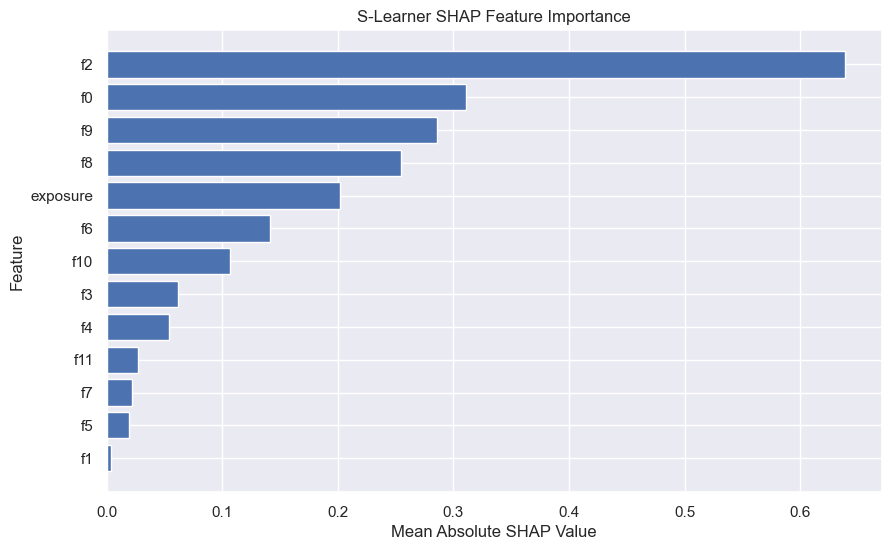

In [35]:
avg_shap = shap_values.abs.mean(0).values
sorted_idx = avg_shap.argsort()

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(sorted_idx)), avg_shap[sorted_idx], align='center')
ax.set_yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
ax.set_xlabel("Mean Absolute SHAP Value")
ax.set_ylabel("Feature")
ax.set_title("S-Learner SHAP Feature Importance")

Text(0.5, 0, 'Uplift Score')

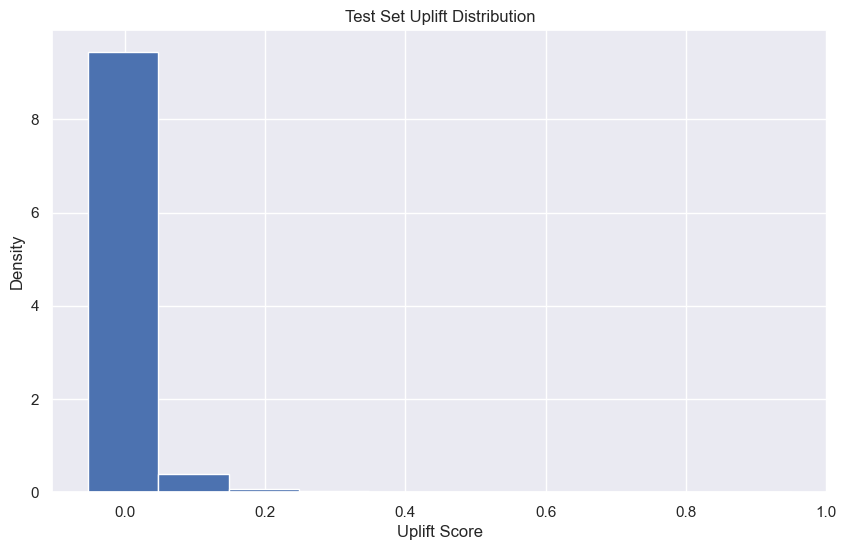

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
_ = ax.hist(uplift_score, density=True)
ax.set_title("Test Set Uplift Distribution")
ax.set_ylabel("Density")
ax.set_xlabel("Uplift Score")

- Perhaps an intuitive way to evaluate an uplift model would be to analyze whether groups of individuals with higher uplift scores tend to have higher average treatment effects than those with lower uplift scores.

In [37]:
def get_qini_data(uplift_score:np.ndarray, treatment:np.ndarray, outcome:np.ndarray):
    
    # Sort data according to uplift scores in descending order
    sorted_uplift_idx = np.argsort(uplift_score)[::-1]
    
    treatment_sorted = treatment[sorted_uplift_idx]
    outcome_sorted = outcome[sorted_uplift_idx]

    # Compute total number of obs in treatment and control group
    n_treatment = np.sum(treatment_sorted == 1)
    n_control = np.sum(treatment_sorted == 0)

    # Compute the cumulative number of positive outcomes in the control group
    control_positive_cum = np.cumsum((treatment_sorted == 0) & (outcome_sorted == 1))

    # Compute the cumulative number of positive outcomes in the treatment group
    treatment_positive_cum = np.cumsum((treatment_sorted == 1) & (outcome_sorted == 1))

    # Compute the cumulative success rate for the treatment and control groups
    control_cum_success_rate = control_positive_cum / n_control
    treatment_cum_success_rate = treatment_positive_cum / n_treatment

    # Compute the cumulative uplift
    cum_uplift = treatment_cum_success_rate - control_cum_success_rate

    # Compute the cumulative proportion of target obs
    cum_prop_target = np.ones(n_treatment + n_control).cumsum() / (n_treatment + n_control)
    
    qini_auc = auc(cum_prop_target, cum_uplift)
    
    return {
        "cum_prop_targeted":cum_prop_target,
        "cum_uplift":cum_uplift,
        "qini_auc":qini_auc
    }

In [38]:
model_results = get_qini_data(uplift_score,
                              x_test.select("exposure").to_numpy().reshape(-1, ),
                              y_test.to_numpy().reshape(-1, ))

random_uplifts = np.random.choice([0, 1], p=[0.96, 0.04], size=len(uplift_score))

model_random = get_qini_data(random_uplifts,
                             x_test.select("exposure").to_numpy().reshape(-1, ),
                             y_test.to_numpy().reshape(-1, ))

model_perfect = get_qini_data(y_test.to_numpy().reshape(-1, ),
                             x_test.select("exposure").to_numpy().reshape(-1, ),
                             y_test.to_numpy().reshape(-1, ))
model_perfect

{'cum_prop_targeted': array([1.66666667e-06, 3.33333333e-06, 5.00000000e-06, ...,
        9.99996667e-01, 9.99998333e-01, 1.00000000e+00]),
 'cum_uplift': array([-1.71992708e-06,  5.21013862e-05,  1.05922699e-04, ...,
         5.38339026e-02,  5.38339026e-02,  5.38339026e-02]),
 'qini_auc': 0.05375343504200934}

Text(0, 0.5, 'Uplift')

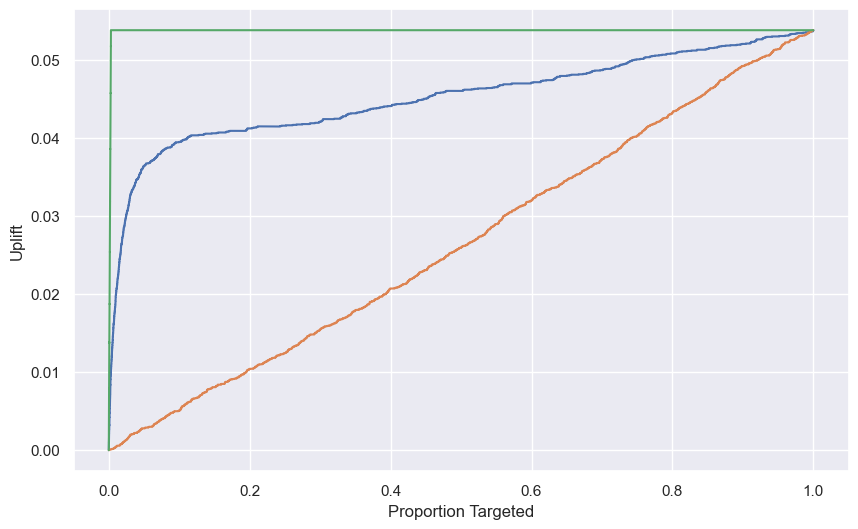

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(model_results["cum_prop_targeted"], model_results["cum_uplift"])
ax.plot(model_random["cum_prop_targeted"], model_random["cum_uplift"])
ax.plot(model_perfect["cum_prop_targeted"], model_perfect["cum_uplift"])
ax.set_xlabel("Proportion Targeted")
ax.set_ylabel("Uplift")

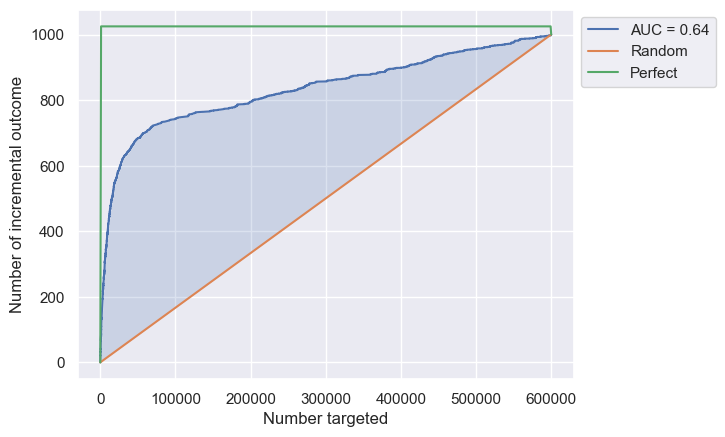

In [40]:
plot_qini_curve(y_test.to_numpy().reshape(-1, ),
                uplift_score,
                x_test.select("exposure").to_numpy().reshape(-1, ))

In [41]:
qini_auc_score(y_test.to_numpy().reshape(-1, ),
                uplift_score,
                x_test.select("exposure").to_numpy().reshape(-1, )
)
                    

0.637822146229158

In [42]:
auc_score_baseline = model_random["qini_auc"]
auc_score_perfect = model_perfect["qini_auc"] - auc_score_baseline
auc_score_actual = model_results["qini_auc"] - auc_score_baseline

auc_score_actual / auc_score_perfect

0.6855564759130509